In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from os.path import join
from ast import literal_eval as make_tuple
from scipy.stats import zscore
import numpy as np
from matplotlib.legend import _get_legend_handles_labels

In [16]:
def capacity_factors_model(model):
    cp_fact = pd.read_csv("/home/users/train014/Repositories/group_5/data/cap_factor_input_all_periods_{}.csv".format(model))
    cp_fact = cp_fact.rename(columns={"Unnamed: 0": "bus_carrier"}).set_index("bus_carrier")
    cp_fact = pd.DataFrame(cp_fact.stack()).rename(columns={0:"capacity_factor"}).reset_index()
    cp_fact.rename(columns={"level_1":"period_stat"}, inplace=True)
    cp_fact["period_stat"] = cp_fact["period_stat"].apply(lambda x: make_tuple(x))
    cp_fact["period"] = cp_fact["period_stat"].apply(lambda x: x[0])
    cp_fact["stat"] = cp_fact["period_stat"].apply(lambda x: x[1])
    cp_fact["bus_carrier"] = cp_fact["bus_carrier"].str.split(" ")
    cp_fact["bus"] = cp_fact["bus_carrier"].apply(lambda x: x[0])
    cp_fact["carrier"] = cp_fact["bus_carrier"].apply(lambda x: x[1])
    cp_fact = cp_fact[["period", "bus", "carrier",  "stat", "capacity_factor"]]
    cp_fact = cp_fact.groupby(["period", "bus", "carrier", "stat"]).mean()
    cp_fact_out = cp_fact.loc[:,:,:,"ave"].copy().rename(columns= {"capacity_factor":"capacity_factor_min"})
    for stat in ["ave", "max"]:
        cp_fact_out["capacity_factor_{}".format(stat)] = cp_fact.loc[:,:,:,stat]
    return cp_fact_out

def lcoe_model(model):
    filepath = Path("/home/users/train014/Repositories/group_5/data/lceo_per_carrier_per_node_all_periods_model_{}.csv".format(model))
    model_data = pd.read_csv(filepath)
    model_data = model_data.set_index(["bus", "carrier"]).stack().reset_index().rename(columns={0:"LCOE",                                                                                      
                                                                           "level_2": "period"})
    model_data = model_data.set_index(["period","bus", "carrier"])
    return model_data

def lcoe_model(model):
    filepath = Path("/home/users/train014/Repositories/group_5/data/lceo_per_carrier_per_node_all_periods_model_{}.csv".format(model))
    model_data = pd.read_csv(filepath)
    model_data = model_data.set_index(["bus", "carrier"]).stack().reset_index().rename(columns={0:"LCOE",                                                                                      
                                                                           "level_2": "period"})
    model_data = model_data.set_index(["period","bus", "carrier"])
    return model_data

In [17]:
cap_factors_CNRM_indexed = capacity_factors_model("CNRM").reset_index()
cap_factors_CNRM_indexed["model"] = "CNRM"
#cap_factors_CNRM_indexed = cap_factors_CNRM_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_ICHEC_indexed = capacity_factors_model("ICHEC").reset_index()
cap_factors_ICHEC_indexed["model"] = "ICHEC"
#cap_factors_ICHEC_indexed = cap_factors_ICHEC_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_MPI_indexed = capacity_factors_model("MPI").reset_index()
cap_factors_MPI_indexed["model"] = "MPI"
#cap_factors_MPI_indexed = cap_factors_MPI_indexed.groupby(["model","period", "bus", "carrier"]).mean()
cap_factors_all = pd.concat([cap_factors_CNRM_indexed, cap_factors_ICHEC_indexed, cap_factors_MPI_indexed],
                            ignore_index = True)
cap_factors_all = cap_factors_all.groupby(["model","period", "bus", "carrier"]).mean()


In [18]:
lcoe_CNRM_indexed = lcoe_model("CNRM").reset_index()
lcoe_CNRM_indexed["model"] = "CNRM"
#lcoe_CNRM_indexed = lcoe_CNRM_indexed.groupby(["model","period", "bus", "carrier"]).mean()
lcoe_ICHEC_indexed = lcoe_model("ICHEC").reset_index()
lcoe_ICHEC_indexed["model"] = "ICHEC"
#lcoe_ICHEC_indexed = lcoe_ICHEC_indexed.groupby(["model","period", "bus", "carrier"]).mean()
lcoe_MPI_indexed= lcoe_model("MPI").reset_index()
lcoe_MPI_indexed["model"] = "MPI"
#lcoe_MPI_indexed = lcoe_MPI_indexed.groupby(["model","period", "bus", "carrier"]).mean()
lcoa_all = pd.concat([lcoe_CNRM_indexed, lcoe_ICHEC_indexed, lcoe_MPI_indexed],
                            ignore_index = True)
lcoa_all = lcoa_all.groupby(["model","period", "bus", "carrier"]).mean()

In [19]:
all_joined = pd.merge(cap_factors_all, lcoa_all, left_index=True, right_index=True, how='outer')
all_joined = all_joined.dropna()

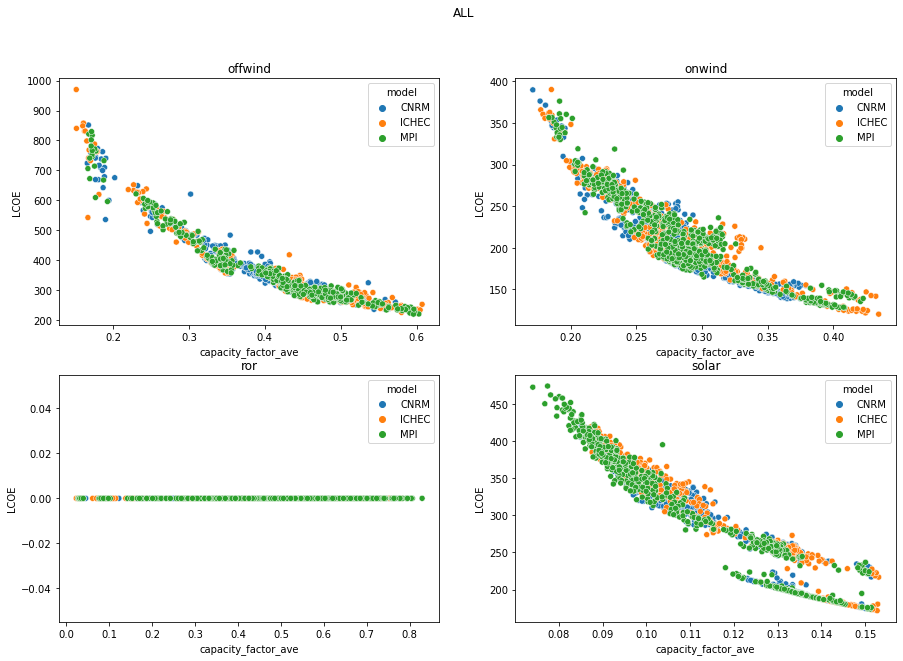

In [32]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("ALL")
axes_pointer = axes.flatten()
for i, carrier in enumerate(['offwind', 'onwind', 'ror', 'solar']):
    sns.scatterplot(data=all_joined.loc[:,:,:,carrier], x="capacity_factor_ave", y="LCOE", hue="model",
                    ax = axes_pointer[i], legend = True)
    axes_pointer[i].set_title(carrier)
    axes_pointer[i].set_xlabel("Capacity Factor")
    axes_pointer[i].set_xlabel("LCOE €")
    #axes_pointer[i].set(yscale="log")

In [10]:
# 4 times [per carrier]
# 30 plots
# each plot for a node
# cap vs lcoe for 1 carrier
# With the three models

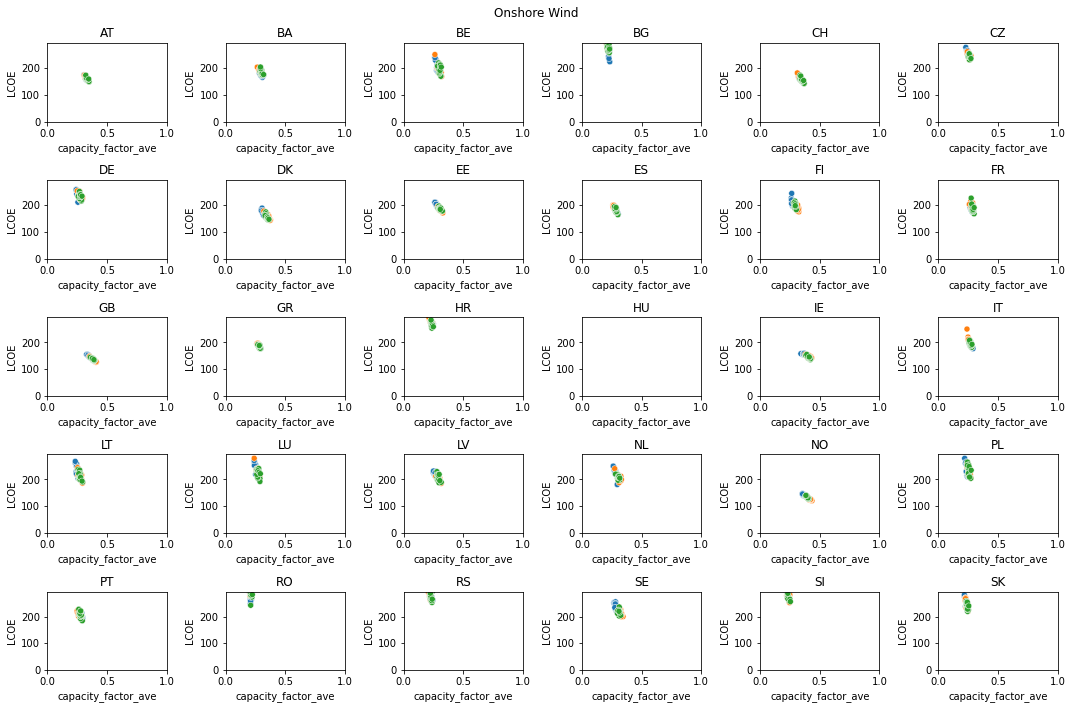

In [33]:
onwind_lcoe = all_joined.loc[:,:,:,"onwind"]
onwind_lcoe.index.levels[2].shape
fig, axes = plt.subplots(5,6, figsize=(15,10))
fig.suptitle("Onshore Wind")
axes_pointer = axes.flatten()
for i, node in enumerate(onwind_lcoe.index.levels[2]):
    sns.scatterplot(data=onwind_lcoe.loc[:,:,node], x="capacity_factor_ave", y="LCOE", hue="model",
                    ax = axes_pointer[i], legend = False)
    axes_pointer[i].set_title(node)
    axes_pointer[i].set_ylim([0,onwind_lcoe.LCOE.quantile(.95)])
    #axes_pointer[i].set(yscale="log")
    axes_pointer[i].set_xlim([0,1])
fig.tight_layout()

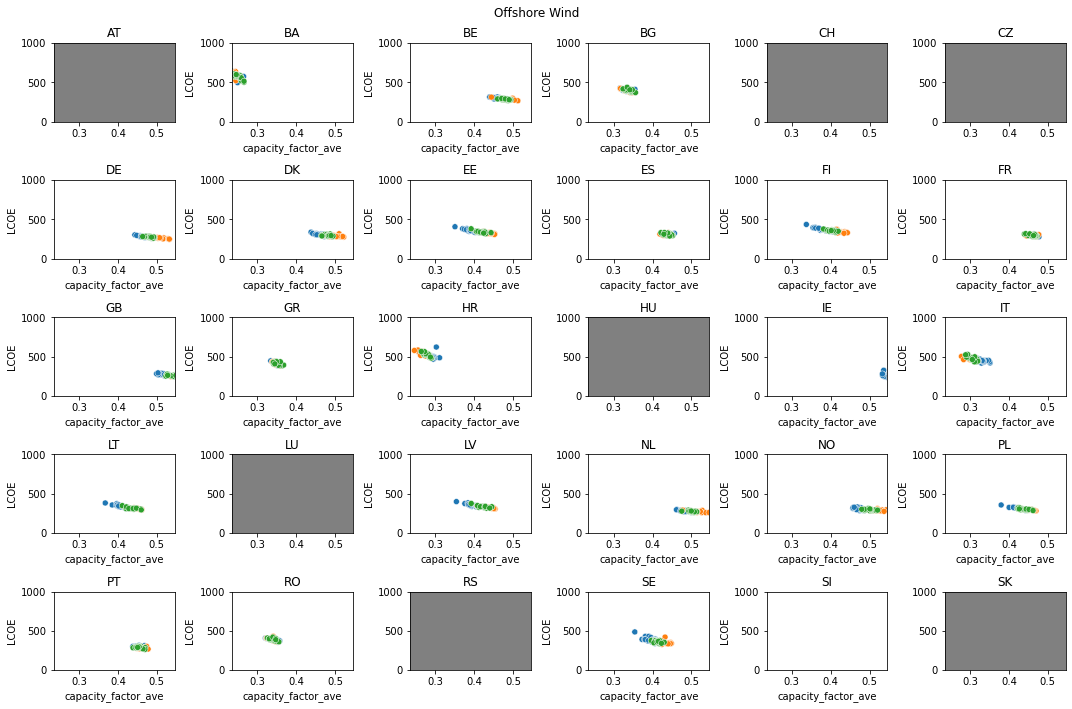

In [34]:
offwind_lcoe = all_joined.loc[:,:,:,"offwind"]
offwind_lcoe.index.levels[2].shape
fig, axes = plt.subplots(5,6, figsize=(15,10))
fig.suptitle("Offshore Wind")
axes_pointer = axes.flatten()
for i, node in enumerate(offwind_lcoe.index.levels[2]):
    try:
        sns.scatterplot(data=offwind_lcoe.loc[:,:,node], x="capacity_factor_ave", y="LCOE", hue="model",
                        ax = axes_pointer[i], legend = False)
    except KeyError:
        axes_pointer[i].set_facecolor("gray")
    axes_pointer[i].set_title(node)
    axes_pointer[i].set_ylim([0,1000])
    #axes_pointer[i].set(yscale="log")
    axes_pointer[i].set_xlim([offwind_lcoe.capacity_factor_ave.quantile(.05),offwind_lcoe.capacity_factor_ave.quantile(.95)])
fig.tight_layout()

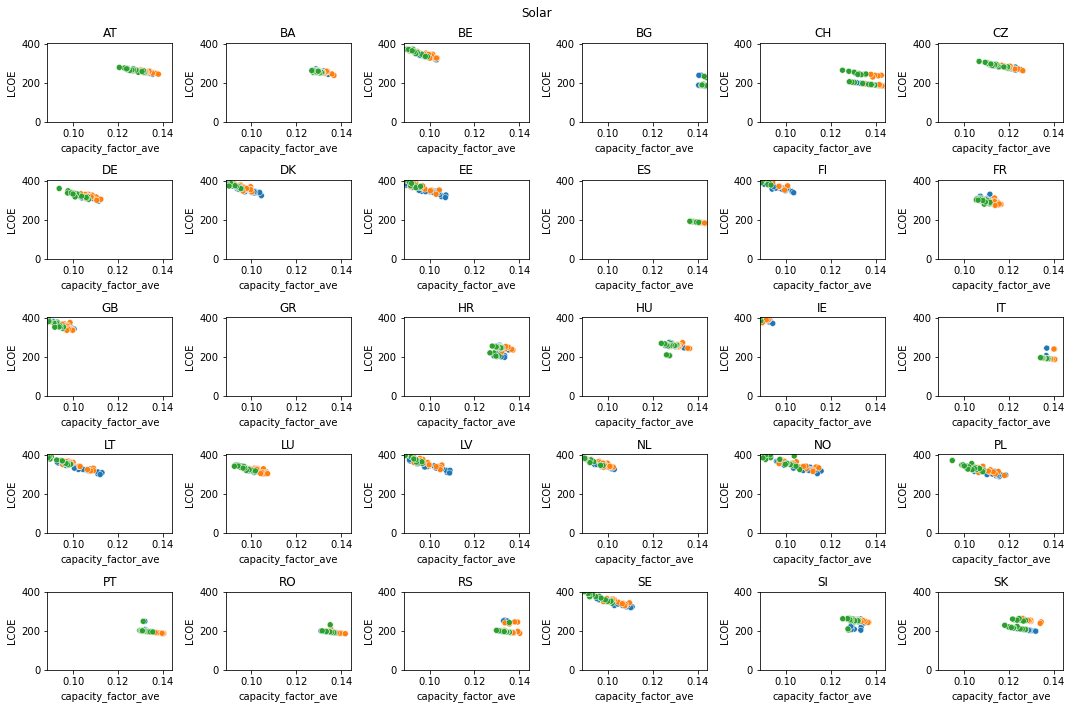

In [30]:
solar_lcoe = all_joined.loc[:,:,:,"solar"]
solar_lcoe.index.levels[2].shape
fig, axes = plt.subplots(5,6, figsize=(15,10))
fig.suptitle("Solar")
axes_pointer = axes.flatten()
for i, node in enumerate(solar_lcoe.index.levels[2]):
    sns.scatterplot(data=solar_lcoe.loc[:,:,node], x="capacity_factor_ave", y="LCOE", hue="model",
                    ax = axes_pointer[i], legend = False)
    axes_pointer[i].set_title(node)
    axes_pointer[i].set_ylim([0,solar_lcoe.LCOE.quantile(.95)])
    axes_pointer[i].set_xlim([solar_lcoe.capacity_factor_ave.quantile(.05),solar_lcoe.capacity_factor_ave.quantile(.95)])
fig.tight_layout()

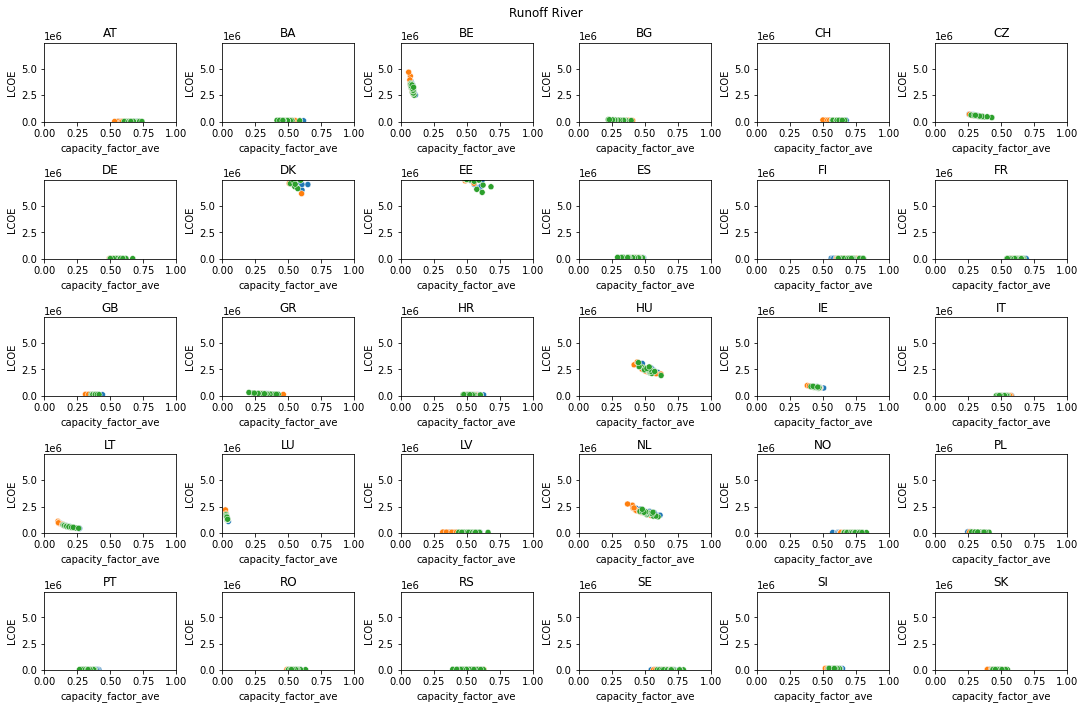

In [69]:
ror_lcoe = all_joined.loc[:,:,:,"ror"]
ror_lcoe.index.levels[2].shape
fig, axes = plt.subplots(5,6, figsize=(15,10))
fig.suptitle("Runoff River")
axes_pointer = axes.flatten()
for i, node in enumerate(ror_lcoe.index.levels[2]):
    sns.scatterplot(data=ror_lcoe.loc[:,:,node], x="capacity_factor_ave", y="LCOE", hue="model",
                    ax = axes_pointer[i], legend = False)
    axes_pointer[i].set_title(node)
    axes_pointer[i].set_ylim([0,ror_lcoe.LCOE.quantile(.95)])
    axes_pointer[i].set_xlim([0,1])
fig.tight_layout()